# Data 102 Fall 2021 Lecture 3 (updated for lecture 4)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

sns.set()  # This helps make our plots look nicer

In [2]:
def make_2x2_table(reality, decisions):
    return pd.DataFrame(
        confusion_matrix(reality, decisions),
        columns = ["D=0", "D=1"],
        index = ["R=0", "R=1"]
    )

## Review: comparing row-wise and column-wise rates

The FDP is the column-wise error rate for when our decision is 1. It asks: how many of the discoveries we made (i.e., our decision was 1) were false (wrong)?

We can relate this to row-wise rates using Bayes' rule. To simplify notation, we'll use $\pi_0 = P(R =0)$.

$$
\begin{align*}
FDP 
&= P(R=0|D=1) \\ 
{\tiny{\text{(using Bayes' rule)}}} &= \frac{P(D=1|R=0)P(R=0)}{P(D=1)} \\ 
{\tiny{\text{(Law of total probability)}}} &= \frac{P(D=1|R=0)P(R=0)}{P(D=1|R=0)P(R=0) + P(D=1|R=1)P(R=1)} \\
{\tiny{\text{(dividing by the numerator)}}} &= \frac{1}{1 + \frac{P(D = 1 | R = 1)}{P(D=1 | R=0)} \frac{P(R = 1)}{P(R=0)}}\\
{\tiny{\text{(applying definitions)}}} &= \frac{1}{1 + \frac{TPR}{FPR} \frac{1 - \pi_0}{\pi_0}}
\end{align*}
$$

In [3]:
def compute_fdp(tpr, fpr, prevalence):
    return 1 / (1 + (tpr/fpr) * (prevalence / (1 - prevalence)))

Suppose we have an algorithm that predicts whether or not it'll rain. We apply our algorithm in Berkeley (where it almost never rains in the summer) and in Miami, FL (where it rains about half the time in the summer).

In [4]:
# Summer in Miami, good test
compute_fdp(tpr=0.99, fpr=0.01, prevalence=0.5)

0.01

In [5]:
# Summer in Berkeley, good test
compute_fdp(tpr=0.99, fpr=0.01, prevalence=0.01)

0.5

In [6]:
# Summer in Miami, bad test
compute_fdp(tpr=0.6, fpr=0.4, prevalence=0.5)

0.4

In [7]:
# Summer in Berkeley, bad test
compute_fdp(tpr=0.6, fpr=0.4, prevalence=0.01)

0.9850746268656717

## Decisions by thresholding: binary classification

In this section, we'll work with a dataset predicting breast cancer from biopsy data.

In [3]:
dataset = load_breast_cancer()
X = pd.DataFrame(dataset['data'], columns = dataset['feature_names'])
y = dataset['target']

# Randomly flip 20% of the outputs to make the problem a little harder
np.random.seed(42)
mask = np.random.random(y.shape) < 0.2
y[mask] = 1 - y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33, random_state = 42
)

In [4]:
# For more information on the dataset, uncomment and run this:
# print(dataset["DESCR"])

Let's use logistic regression to predict y from X:

In [5]:
model = LogisticRegression(solver = "liblinear")
model.fit(X_train, y_train)
y_hat_test = model.predict(X_test)

Now, we can use our 2x2 table to evaluate the performance:

In [6]:
make_2x2_table(reality=y_test, decisions=y_hat_test)

,D=0,D=1
R=0,41,32
R=1,16,99


*Check: what is the false positive rate for these predictions? What about the false discovery rate?*

For patients with cancer (R=1), we're correct $86\%$ of the time. What if this isn't enough? Suppose we need a higher true positive rate: what can we do?

Recall that a logistic regression model's predictions are probabilities between 0 and 1: we always threshold these to obtain binary decisions.

So, let's look at the probabilities directly:

In [7]:
predicted_probs = model.predict_proba(X_test)[:, 1]
predicted_probs.round(2)

array([0.59, 0.35, 0.45, 0.81, 0.82, 0.14, 0.18, 0.42, 0.43, 0.75, 0.7 ,
       0.46, 0.71, 0.52, 0.71, 0.44, 0.73, 0.88, 0.79, 0.2 , 0.63, 0.75,
       0.14, 0.78, 0.77, 0.75, 0.76, 0.81, 0.73, 0.28, 0.74, 0.77, 0.65,
       0.7 , 0.78, 0.72, 0.53, 0.65, 0.42, 0.64, 0.78, 0.44, 0.71, 0.73,
       0.8 , 0.65, 0.71, 0.78, 0.65, 0.74, 0.39, 0.32, 0.66, 0.78, 0.67,
       0.69, 0.76, 0.05, 0.66, 0.76, 0.69, 0.2 , 0.11, 0.68, 0.77, 0.6 ,
       0.29, 0.1 , 0.81, 0.69, 0.45, 0.43, 0.78, 0.52, 0.7 , 0.7 , 0.71,
       0.59, 0.8 , 0.67, 0.49, 0.76, 0.66, 0.12, 0.41, 0.42, 0.22, 0.28,
       0.79, 0.74, 0.68, 0.66, 0.67, 0.9 , 0.81, 0.74, 0.29, 0.33, 0.79,
       0.38, 0.46, 0.8 , 0.39, 0.41, 0.65, 0.67, 0.73, 0.11, 0.7 , 0.62,
       0.42, 0.73, 0.64, 0.48, 0.41, 0.14, 0.81, 0.68, 0.75, 0.46, 0.59,
       0.77, 0.68, 0.33, 0.67, 0.17, 0.46, 0.66, 0.72, 0.28, 0.45, 0.35,
       0.66, 0.78, 0.66, 0.49, 0.68, 0.78, 0.56, 0.43, 0.74, 0.41, 0.77,
       0.79, 0.51, 0.74, 0.34, 0.23, 0.54, 0.72, 0.

The predictions we used earlier were based on thresholding these probabilities at $0.5$. What if we try a different threshold?

If we want to do better than $86\%$ on patients with cancer, should the threshold be higher or lower than $0.5$? Experiment with different thresholds in this cell. What do you find?

In [13]:
threshold = 0.5
y_preds = (predicted_probs > threshold).astype(int)
make_2x2_table(y_test, y_preds)

,D=0,D=1
R=0,41,32
R=1,16,99


Let's visualize these predictions and our threshold:


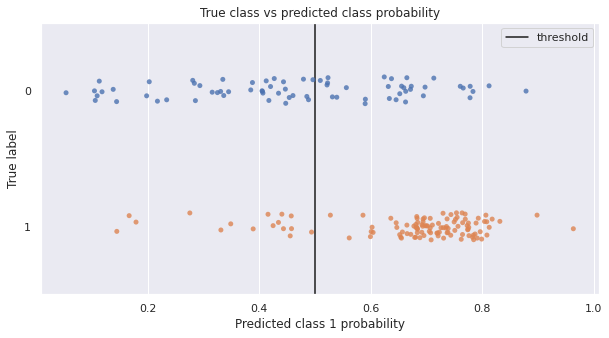

In [8]:
threshold = 0.5

plt.figure(figsize = (10,5))
sns.stripplot(x=predicted_probs, y=y_test, alpha = 0.8, order = [0, 1], orient = "h")
plt.axvline(threshold, c = "k", label = "threshold")
plt.xlabel("Predicted class 1 probability")
plt.ylabel("True label")
plt.title("True class vs predicted class probability")
plt.legend()
plt.show()

The blue points on the top correspond to healthy patients (R=0), and the orange points on the bototm correspond to cancer patients (R=1). For any point that falls to the left of the black line, we declare D=0.

Using this plot, where do we need to set the threshold to guarantee all the cancer patients (blue points) are classified correctly?

### ROC curves

Instead of trying one threshold at a time and seeing what we get, it would be nice if we could visualize the results from multiple thresholds all at once. This is what an ROC curve is for.

In [15]:
def get_tpr_fpr(reality, decision_probs, threshold):
    # Compute the denominators for the top and bottom rows (reality=0, reality=1)
    r1_count = reality.sum()
    r0_count = (1-reality).sum()
    decisions = (decision_probs >= threshold).astype(int)
    table = confusion_matrix(reality, decisions)
    tp_count = table[1,1]
    fp_count = table[0,1]
    tpr = tp_count / r1_count
    fpr = fp_count / r0_count
    
    return tpr, fpr

In [16]:
results = []
thresholds = np.arange(0, 1.01, 0.1)
for threshold in thresholds:
    TPR, FPR = get_tpr_fpr(y_test, predicted_probs, threshold)
    results.append((threshold, TPR, FPR))
results = pd.DataFrame(results, columns = ["threshold", "TPR", "FPR"])
results

,threshold,TPR,FPR
0,0.0,1.000000,1.000000
1,0.1,1.000000,0.986301
2,0.2,0.973913,0.876712
3,0.3,0.965217,0.780822
4,0.4,0.939130,0.671233
5,0.5,0.860870,0.438356
6,0.6,0.826087,0.315068
7,0.7,0.521739,0.109589
8,0.8,0.078261,0.027397
9,0.9,0.008696,0.000000


Text(0.5, 1.0, 'FPR vs TPR')

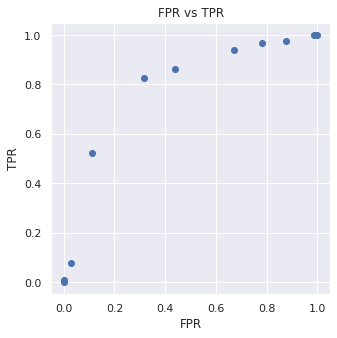

In [17]:
plt.figure(figsize=(5, 5))
plt.scatter(results["FPR"], results["TPR"])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("FPR vs TPR")

Text(0.5, 1.0, 'FPR vs TPR')

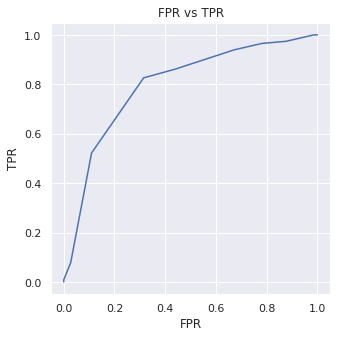

In [18]:
plt.figure(figsize=(5, 5))
plt.plot(results["FPR"], results["TPR"])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("FPR vs TPR")

#### ROC curves in scikit-learn

It turns out `scikit-learn` already does (almost) all this work for us, using the `roc_curve` function.

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

In [20]:
fpr, tpr, _ = roc_curve(y_test, predicted_probs)

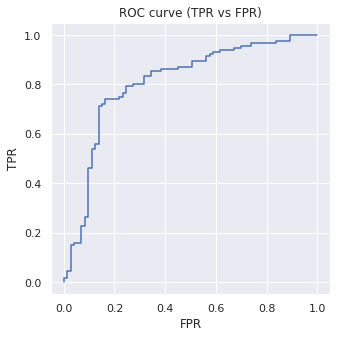

In [21]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("ROC curve (TPR vs FPR)")
plt.show()

### Precision-recall curves

The ROC curve is useful if we want to compare the tradeoff between doing well when reality = 0 and doing well when reality = 1 (in other words, between performance in the top row and bottom of our table).

We can also look at the tradeoff between FDP (column-wise performance for the right column) and TPR (row-wise performance for the bottom row). The standard way that people do this is by plotting a precision-recall curve. The precision is defined to be 1 - FDP (in other words, when we make a discovery, how often is that discovery correct?).

In [22]:
from sklearn.metrics import precision_recall_curve

In [23]:
precision, recall, _ = precision_recall_curve(y_test, predicted_probs)

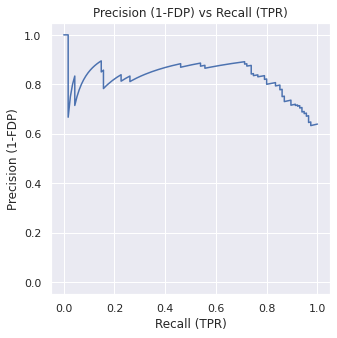

In [24]:
plt.figure(figsize = (5, 5))
plt.plot(recall, precision)
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (1-FDP)")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Precision (1-FDP) vs Recall (TPR)")
plt.show()

## Multiple hypothesis testing and error control

In [88]:
p_values = pd.read_csv('pvalues_more.csv')
p_sorted = p_values.sort_values('pvalue')
p_values.head()

,pvalue,is_alternative
0,0.226410,1
1,0.053205,1
2,0.001128,1
3,0.404488,1
4,0.401786,0


<AxesSubplot:xlabel='pvalue', ylabel='is_alternative'>

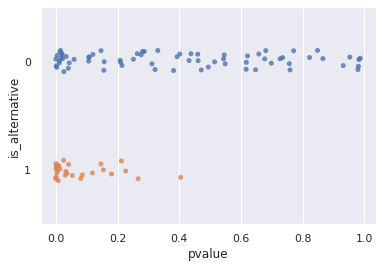

In [89]:
sns.stripplot(
    data=p_values, x='pvalue', y='is_alternative', 
    alpha = 0.8, order = [0, 1], orient = "h"
)

In [90]:
N = 100
k = np.arange(1, N+1)
alpha = .05

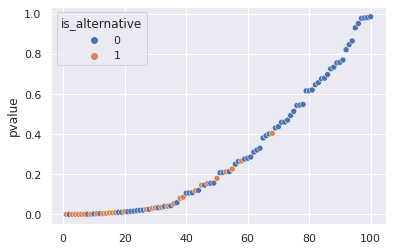

In [91]:
sns.scatterplot(x=k, y=p_sorted['pvalue'], hue=p_sorted['is_alternative']);

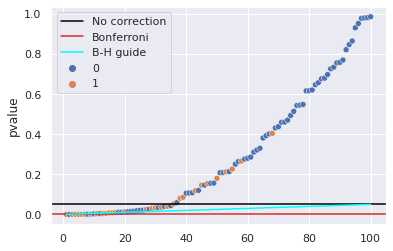

In [92]:
sns.scatterplot(x=k, y=p_sorted['pvalue'], hue=p_sorted['is_alternative']);
plt.axhline(alpha, label='No correction', color='black')
plt.axhline(alpha / N, label='Bonferroni', color='tab:red')
plt.plot(k, k/N * alpha, label='B-H guide', color='cyan')
plt.legend();

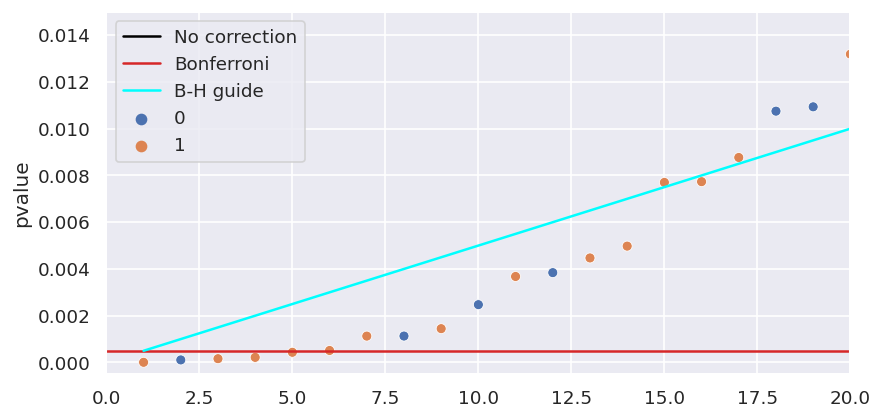

In [100]:
plt.figure(figsize=(8, 4), dpi=120)
sns.scatterplot(x=k, y=p_sorted['pvalue'], hue=p_sorted['is_alternative'])
plt.axhline(alpha, label='No correction', color='black')
plt.axhline(alpha / N, label='Bonferroni', color='tab:red')
plt.plot(k, k/N * alpha, label='B-H guide', color='cyan')
plt.legend()

plt.axis([-0.0001, 20, -0.0005, .015]);